In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 219M/219M [00:03<00:00, 64.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1


In [ ]:
import os
from tensorflow import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print('GPU is Available!')
else:
  print('GPU is Unavailable!')

GPU is Unavailable!


In [ ]:
source = path + "/Rice_Image_Dataset"

In [ ]:
print(os.listdir(source))

['Jasmine', 'Arborio', 'Karacadag', 'Rice_Citation_Request.txt', 'Basmati', 'Ipsala']


In [ ]:
# Initialize empty lists for storing the images and labels
images = []
labels = []

for subfolder in os.listdir(source):

    subfolder_path = os.path.join(source, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

 # Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

In [ ]:
unique_labels = df['label'].value_counts()
num_classes = len(unique_labels)

In [ ]:
df.head()

,image,label
0,/root/.cache/kagglehub/datasets/muratkokludata...,Jasmine
1,/root/.cache/kagglehub/datasets/muratkokludata...,Jasmine
2,/root/.cache/kagglehub/datasets/muratkokludata...,Jasmine
3,/root/.cache/kagglehub/datasets/muratkokludata...,Jasmine
4,/root/.cache/kagglehub/datasets/muratkokludata...,Jasmine


In [ ]:
df.shape

(75000, 2)

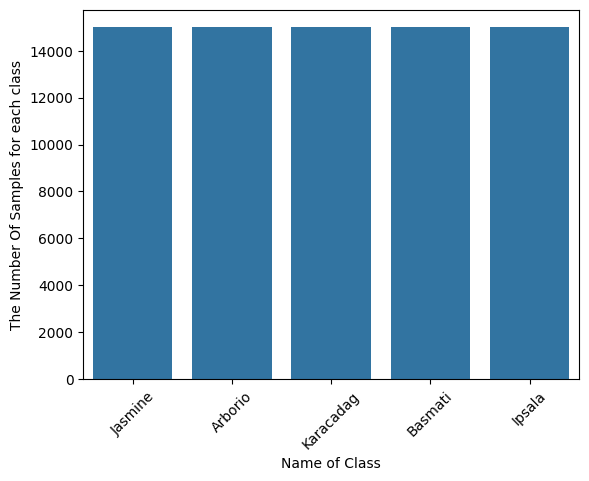

In [ ]:
# plot the classes
ax = sns.countplot(x=df.label)

ax.set_xlabel("Name of Class")
ax.set_ylabel("The Number Of Samples for each class")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42)

# Create a dataframe for the training data
df_train = pd.DataFrame({'image': X_train, 'label': y_train})

# Create a dataframe for the test data
df_test = pd.DataFrame({'image': X_test, 'label': y_test})

# Encode the labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
# Set the image size and batch size
image_size = (128, 128)
batch_size = 32

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the test data
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 60000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.


In [ ]:
class_indices = train_generator.class_indices
print(class_indices)

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


In [ ]:
# Load MobileNetV2 without top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=5
)

Epoch 1/5
 542/1875 ━━━━━━━━━━━━━━━━━━━━ 13:03 588ms/step - accuracy: 0.9508 - loss: 0.1414

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


 970/1875 ━━━━━━━━━━━━━━━━━━━━ 8:48 584ms/step - accuracy: 0.9556 - loss: 0.1272

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1288/1875 ━━━━━━━━━━━━━━━━━━━━ 5:42 583ms/step - accuracy: 0.9576 - loss: 0.1215

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1597/1875 ━━━━━━━━━━━━━━━━━━━━ 2:41 582ms/step - accuracy: 0.9590 - loss: 0.1177

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9600 - loss: 0.1149

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1360s 725ms/step - accuracy: 0.9600 - loss: 0.1149 - val_accuracy: 0.9645 - val_loss: 0.1004
Epoch 2/5
 168/1875 ━━━━━━━━━━━━━━━━━━━━ 16:13 570ms/step - accuracy: 0.9741 - loss: 0.0843

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1090/1875 ━━━━━━━━━━━━━━━━━━━━ 7:29 573ms/step - accuracy: 0.9744 - loss: 0.0760

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1112/1875 ━━━━━━━━━━━━━━━━━━━━ 7:16 572ms/step - accuracy: 0.9744 - loss: 0.0760

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1697/1875 ━━━━━━━━━━━━━━━━━━━━ 1:41 572ms/step - accuracy: 0.9743 - loss: 0.0754

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9743 - loss: 0.0753

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1379s 713ms/step - accuracy: 0.9743 - loss: 0.0753 - val_accuracy: 0.9511 - val_loss: 0.1382
Epoch 3/5
 479/1875 ━━━━━━━━━━━━━━━━━━━━ 13:10 566ms/step - accuracy: 0.9743 - loss: 0.0672

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1337s 713ms/step - accuracy: 0.9751 - loss: 0.0682 - val_accuracy: 0.9797 - val_loss: 0.0630
Epoch 4/5
 417/1875 ━━━━━━━━━━━━━━━━━━━━ 13:47 568ms/step - accuracy: 0.9766 - loss: 0.0629

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


 660/1875 ━━━━━━━━━━━━━━━━━━━━ 11:34 572ms/step - accuracy: 0.9768 - loss: 0.0636

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1073/1875 ━━━━━━━━━━━━━━━━━━━━ 7:38 571ms/step - accuracy: 0.9770 - loss: 0.0639

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1212/1875 ━━━━━━━━━━━━━━━━━━━━ 6:18 572ms/step - accuracy: 0.9771 - loss: 0.0640

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1347s 718ms/step - accuracy: 0.9774 - loss: 0.0640 - val_accuracy: 0.9779 - val_loss: 0.0610
Epoch 5/5
 306/1875 ━━━━━━━━━━━━━━━━━━━━ 15:24 589ms/step - accuracy: 0.9776 - loss: 0.0686

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


 595/1875 ━━━━━━━━━━━━━━━━━━━━ 12:30 586ms/step - accuracy: 0.9784 - loss: 0.0658

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


 657/1875 ━━━━━━━━━━━━━━━━━━━━ 11:53 586ms/step - accuracy: 0.9785 - loss: 0.0654

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1334/1875 ━━━━━━━━━━━━━━━━━━━━ 5:16 585ms/step - accuracy: 0.9789 - loss: 0.0635

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1407/1875 ━━━━━━━━━━━━━━━━━━━━ 4:33 585ms/step - accuracy: 0.9789 - loss: 0.0635

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1420s 728ms/step - accuracy: 0.9789 - loss: 0.0632 - val_accuracy: 0.9808 - val_loss: 0.0558


In [ ]:
model.save("rice_classifier.h5")
print("✅ Model saved successfully.")

✅ Model saved successfully.


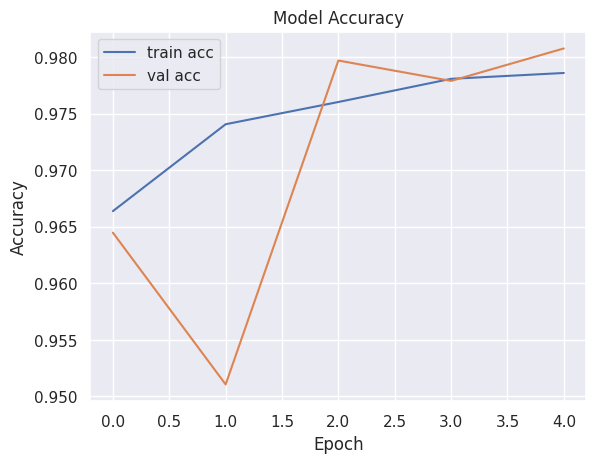

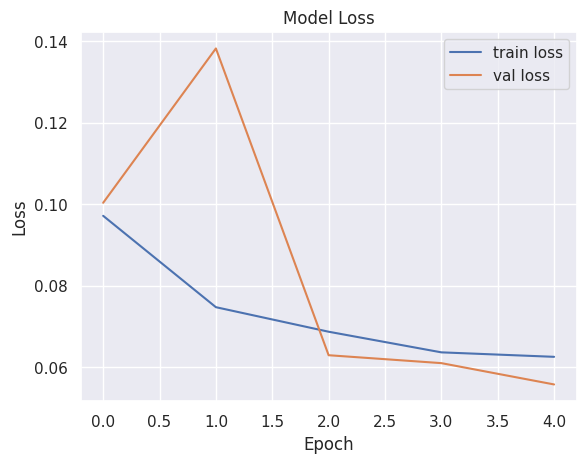

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data
metrics = model.evaluate(test_generator)
# Print the accuracy of the model
print('Accuracy:', metrics[1])

469/469 ━━━━━━━━━━━━━━━━━━━━ 270s 575ms/step - accuracy: 0.9801 - loss: 0.0570
Accuracy: 0.9802666902542114
